<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 2
Автор материала: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Тема 10. Бустинг
## <center>Часть 5. Оценка важности признаков с Xgboost

## Загрузка бибилиотек

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(font_scale = 1.5)
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import xgboost as xgb

## Загрузка и подготовка данных

Посмотрим на примере данных по оттоку клиентов из телеком-компании.### Load data<a name='data' />

In [2]:
df = pd.read_csv('../../data/telecom_churn.csv')

In [3]:
df.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


**Штаты просто занумеруем, а признаки International plan (наличие международного роуминга), Voice mail plan (наличие голосовой почтыы) и целевой Churn сделаем бинарными.**

In [4]:
state_enc = LabelEncoder()
df['State'] = state_enc.fit_transform(df['State'])
df['International plan'] = (df['International plan'] == 'Yes').astype('int')
df['Voice mail plan'] = (df['Voice mail plan'] == 'Yes').astype('int')
df['Churn'] = (df['Churn']).astype('int')

**Разделим данные на обучающую и тестовую выборки в отношении 7:3. Инициализируем соотв. объекты DMatrix dtrain и dtest.**

In [5]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('Churn', axis=1), df['Churn'],
                                                    test_size=0.3, stratify=df['Churn'], random_state=17)
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)

### Обучение модели

**Обучим всего 50 деревьев решений глубины 3.**

In [6]:
params = {
    'objective':'binary:logistic',
    'max_depth':3,
    'silent':1,
    'eta':0.5
}

num_rounds = 50

In [7]:
watchlist  = [(dtest,'test'), (dtrain,'train')] # native interface only
xgb_model = xgb.train(params, dtrain, num_rounds, watchlist)

[0]	test-error:0.116	train-error:0.09087
[1]	test-error:0.104	train-error:0.069867
[2]	test-error:0.089	train-error:0.061723
[3]	test-error:0.092	train-error:0.054008
[4]	test-error:0.075	train-error:0.041149
[5]	test-error:0.074	train-error:0.038148
[6]	test-error:0.07	train-error:0.035148
[7]	test-error:0.069	train-error:0.033005
[8]	test-error:0.069	train-error:0.033433
[9]	test-error:0.068	train-error:0.029147
[10]	test-error:0.066	train-error:0.031719
[11]	test-error:0.068	train-error:0.028718
[12]	test-error:0.068	train-error:0.027004
[13]	test-error:0.069	train-error:0.027004
[14]	test-error:0.07	train-error:0.027004
[15]	test-error:0.071	train-error:0.026575
[16]	test-error:0.069	train-error:0.025718
[17]	test-error:0.07	train-error:0.025718
[18]	test-error:0.068	train-error:0.025718
[19]	test-error:0.071	train-error:0.025718
[20]	test-error:0.07	train-error:0.026147
[21]	test-error:0.069	train-error:0.025289
[22]	test-error:0.069	train-error:0.025718
[23]	test-error:0.068	trai

### Важность признаков

**F score при оценке важности признаков в Xgboost (не путать с F1 score как метрики качества классификации) вычисляется на основе того, как часто разбиение делалось по данному признаку.**

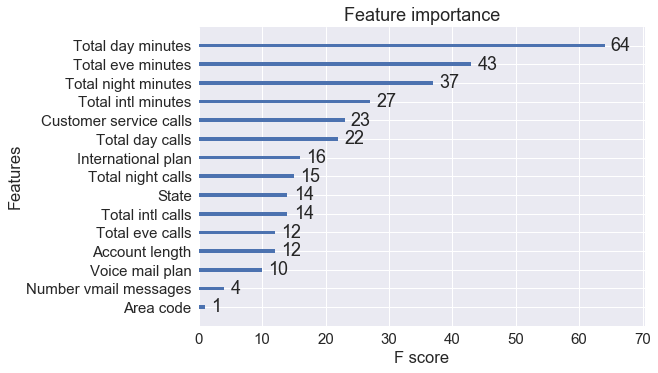

In [8]:
xgb.plot_importance(xgb_model);

**Можно так, в виде словаря или DataFrame:**

In [9]:
importances = xgb_model.get_fscore()
importances

{'Account length': 12,
 'Area code': 1,
 'Customer service calls': 23,
 'International plan': 16,
 'Number vmail messages': 4,
 'State': 14,
 'Total day calls': 22,
 'Total day minutes': 64,
 'Total eve calls': 12,
 'Total eve minutes': 43,
 'Total intl calls': 14,
 'Total intl minutes': 27,
 'Total night calls': 15,
 'Total night minutes': 37,
 'Voice mail plan': 10}

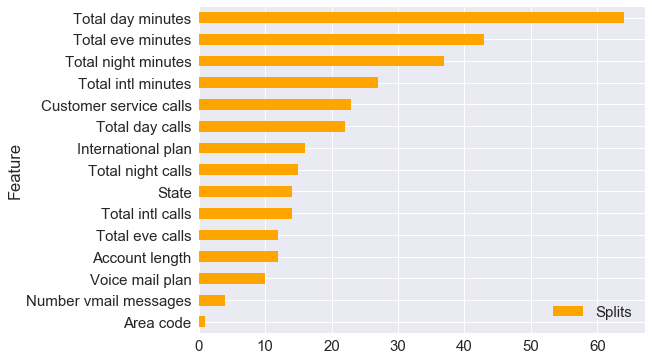

In [11]:
# create df
importance_df = pd.DataFrame({
        'Splits': list(importances.values()),
        'Feature': list(importances.keys())
    })
importance_df.sort_values(by='Splits', inplace=True)
importance_df.plot(kind='barh', x='Feature', figsize=(8,6), color='orange');